<a href="https://colab.research.google.com/github/UtkarshRedd/Deep-Learning-MRI-for-Alzheimers/blob/main/CNN-Alzheimers-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Kaggle Dataset from
https://www.kaggle.com/code/kenconstable/alzheimer-s-multi-class-classification

Make sure to upload the kaggle authentication (kaggle.json) file in order to be able to import the data from the repo

In [78]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

alzheimers-dataset-4-class-of-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Moving the kaggle auth file to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# unzipping the dataset
!unzip /content/alzheimers-dataset-4-class-of-images.zip

In [ ]:
!pip install tensorflow

In [ ]:
! pip install scikit-learn imbalanced-learn

# Multclass Classification

In [206]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV



from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

INIT_LR = 1e-4
EPOCHS = 50
BS = 32

In [207]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.12.0


In [208]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 100

In [209]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

def filter_out_class(images, labels):
    return tf.not_equal(labels, unwanted_class_label)

# Define your unwanted class label. In this case, it is assumed to be 2
unwanted_class_label = 0

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [210]:
# Print class names
print(train_ds.class_names)

# Check the label assigned to 'NonDementia'
non_dementia_label = train_ds.class_names.index('NonDemented')
print(f'Label assigned to NonDementia: {non_dementia_label}')

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Label assigned to NonDementia: 2


In [211]:
# Print class names
print(train_ds.class_names)

# Check the label assigned to 'NonDementia'
non_dementia_label = train_ds.class_names.index('NonDemented')
print(f'Label assigned to NonDementia: {non_dementia_label}')

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Label assigned to NonDementia: 2


In [214]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

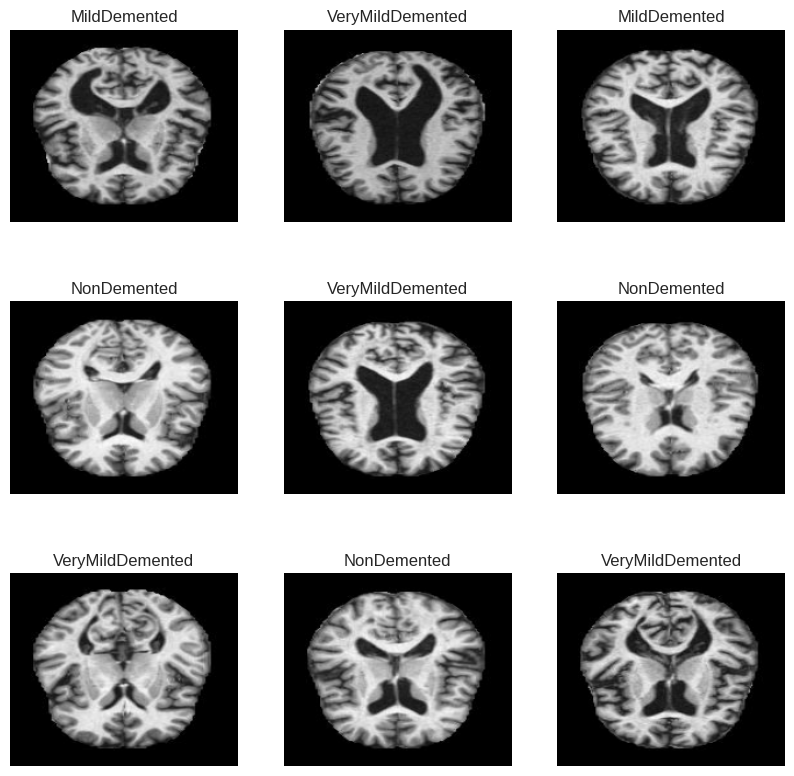

In [215]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [137]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [138]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [139]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "/content/Alzheimer_s Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [140]:
NUM_IMAGES

[2561, 2560]

## Just DL

In [17]:
training_set = train_ds
test_set = val_ds
INIT_LR = 1e-4
EPOCHS = 50
BS = 32

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
    Conv2D(16, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.2),
    Dense(4, activation = 'softmax')
])

# Compile model with recall as a metric
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = [tf.keras.metrics.Recall()])

history = model.fit(train_ds, epochs=25, validation_data=val_ds)


Epoch 1/25
257/257 [==============================] - 13s 9ms/step - loss: 2.9102 - recall: 0.3996 - val_loss: 0.9149 - val_recall: 0.4443
Epoch 2/25
257/257 [==============================] - 2s 7ms/step - loss: 0.8742 - recall: 0.4823 - val_loss: 0.9792 - val_recall: 0.4717
Epoch 3/25
257/257 [==============================] - 2s 7ms/step - loss: 0.7454 - recall: 0.5909 - val_loss: 0.8240 - val_recall: 0.6133
Epoch 4/25
257/257 [==============================] - 2s 7ms/step - loss: 0.6351 - recall: 0.6756 - val_loss: 0.6201 - val_recall: 0.6797
Epoch 5/25
257/257 [==============================] - 2s 7ms/step - loss: 0.5160 - recall: 0.7449 - val_loss: 0.5994 - val_recall: 0.7139
Epoch 6/25
257/257 [==============================] - 2s 7ms/step - loss: 0.3987 - recall: 0.8174 - val_loss: 0.6708 - val_recall: 0.7275
Epoch 7/25
257/257 [==============================] - 2s 7ms/step - loss: 0.3114 - recall: 0.8665 - val_loss: 0.3214 - val_recall: 0.8633
Epoch 8/25
257/257 [=============

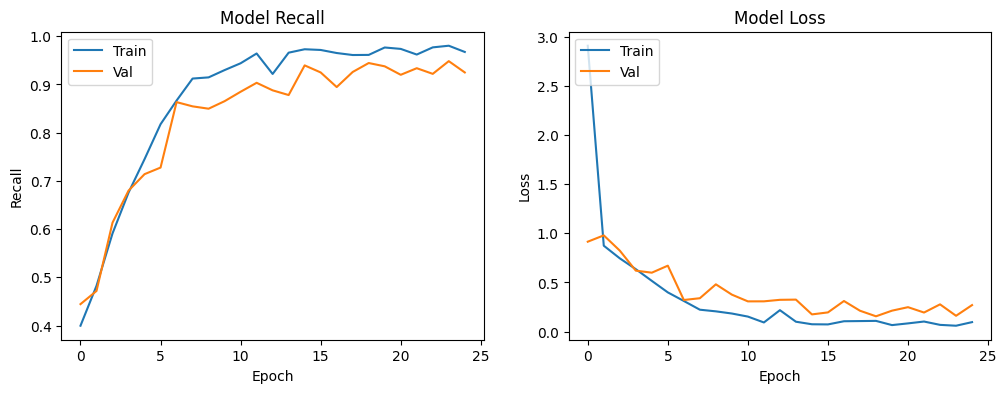

64/64 [==============================] - 0s 3ms/step
                  precision    recall  f1-score   support

    MildDementia       0.93      0.90      0.91       151
ModerateDementia       1.00      0.67      0.80         9
     NonDementia       0.94      0.94      0.94       507
VeryMildDementia       0.91      0.92      0.91       357

        accuracy                           0.93      1024
       macro avg       0.94      0.86      0.89      1024
    weighted avg       0.93      0.93      0.93      1024



In [21]:
# Plot the recall and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Prediction
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion Matrix
# conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
# plt.figure(figsize=(10, 10))
# sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.show()

# Getting a validation Recall of 92.48%

In [22]:
# Testing
# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Map the labels to one-hot encoding
test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Evaluate the model on the test dataset
test_loss, test_recall = model.evaluate(test_ds)

print("Test loss:", test_loss)
print("Test recall:", test_recall)


Found 1279 files belonging to 4 classes.
80/80 [==============================] - 1s 6ms/step - loss: 3.0329 - recall: 0.6255
Test loss: 3.032945156097412
Test recall: 0.6254886388778687


# Getting a Recall of 62.5% on the Testing Data. Needs to be improved.

In [23]:
#Saving the model for future use
work_dir = "/kaggle/working/"
model_dir = work_dir + "alzheimer_cnn_model"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_cnn_model']

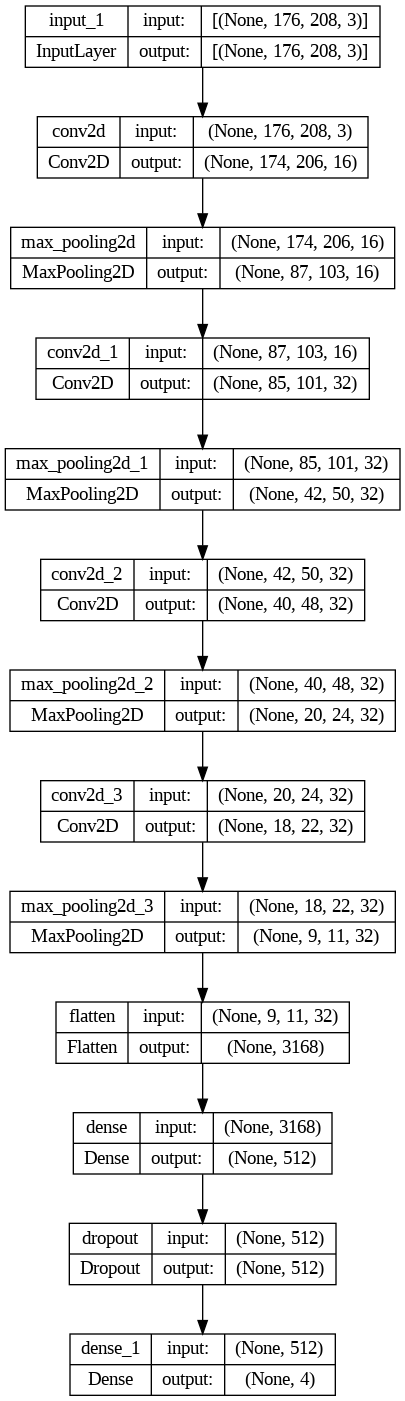

In [24]:
pretrained_model = tf.keras.models.load_model(model_dir)

from keras.utils.vis_utils import plot_model
#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

# DL with ML
Creating a CNN for extracting relevant features. Then training a machine learning model on these features to perform the classification

In [25]:
training_set = train_ds
test_set = val_ds


# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(*IMAGE_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64), # This is the layer we will extract features from
    tf.keras.layers.Dense(4)
])

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.Recall()])

# Train the model. Idel epochs seem to be 20
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

# Get the model up to the last dense layer with 64 neurons
feature_extractor = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=model.layers[-2].output,
)

# Extract features from the training and validation sets
features_train = feature_extractor.predict(train_ds)
features_val = feature_extractor.predict(val_ds)

# Convert labels to numpy arrays
labels_train = np.concatenate([y.numpy().argmax(axis=1) for x, y in train_ds], axis=0)
labels_val = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds], axis=0)

# Convert features and labels to dataframe
df_train = pd.DataFrame(features_train)
df_train['label'] = labels_train

df_val = pd.DataFrame(features_val)
df_val['label'] = labels_val

# Combine train and test data
df = pd.concat([df_train, df_val])

# Reset index
df.reset_index(drop=True, inplace=True)

Epoch 1/20
257/257 [==============================] - 4s 8ms/step - loss: 1.7366 - recall_1: 0.9107 - val_loss: 0.9332 - val_recall_1: 0.9521
Epoch 2/20
257/257 [==============================] - 2s 7ms/step - loss: 0.8523 - recall_1: 0.9270 - val_loss: 0.8708 - val_recall_1: 0.9365
Epoch 3/20
257/257 [==============================] - 2s 7ms/step - loss: 0.7535 - recall_1: 0.9485 - val_loss: 0.8059 - val_recall_1: 0.9561
Epoch 4/20
257/257 [==============================] - 2s 7ms/step - loss: 0.6416 - recall_1: 0.9753 - val_loss: 0.7654 - val_recall_1: 0.9619
Epoch 5/20
257/257 [==============================] - 2s 7ms/step - loss: 0.5454 - recall_1: 0.9800 - val_loss: 0.5543 - val_recall_1: 0.9814
Epoch 6/20
257/257 [==============================] - 2s 7ms/step - loss: 0.4309 - recall_1: 0.9902 - val_loss: 0.5133 - val_recall_1: 0.9854
Epoch 7/20
257/257 [==============================] - 2s 7ms/step - loss: 0.3737 - recall_1: 0.9885 - val_loss: 0.5352 - val_recall_1: 0.9805
Epoch 

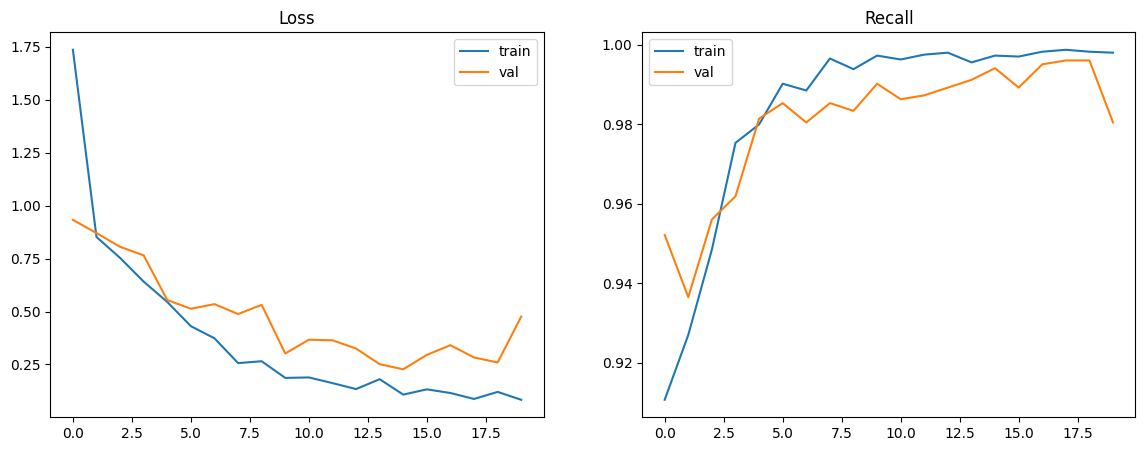

In [27]:
# Plot loss and recall
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['recall_1'], label='train')
plt.plot(history.history['val_recall_1'], label='val')
plt.title('Recall')
plt.legend()
plt.show()



## PyCaret

In [29]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 25.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [30]:
#df.to_csv("/kaggle/working/features_extracted.csv")

In [31]:
from pycaret.classification import *

In [32]:
clf = setup(data = df,
            target = 'label',
            fix_imbalance = True,
            normalize = True
            )

,Description,Value
0,Session id,629
1,Target,label
2,Target type,Multiclass
3,Original data shape,"(5121, 65)"
4,Transformed data shape,"(8705, 65)"
5,Transformed train set shape,"(7168, 65)"
6,Transformed test set shape,"(1537, 65)"
7,Numeric features,64
8,Preprocess,True
9,Imputation type,simple


In [33]:
log_reg = create_model('lr', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9582,0.9942,0.9582,0.9591,0.9583,0.9312,0.9316
1,0.9582,0.9959,0.9582,0.9589,0.9583,0.9307,0.9309
2,0.9665,0.9988,0.9665,0.9687,0.9670,0.9452,0.9456
3,0.9749,0.9984,0.9749,0.9755,0.9751,0.9587,0.9588
4,0.9707,0.9979,0.9707,0.9715,0.9708,0.9519,0.9521
5,0.9874,0.9995,0.9874,0.9889,0.9878,0.9794,0.9794
6,0.9874,0.9997,0.9874,0.9877,0.9875,0.9793,0.9794
7,0.9749,0.9983,0.9749,0.9752,0.9742,0.9586,0.9587
8,0.9791,0.9989,0.9791,0.9793,0.9790,0.9658,0.9660


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [34]:
et = create_model('et', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9623,0.9957,0.9623,0.9624,0.9624,0.9378,0.9379
1,0.9623,0.9959,0.9623,0.9627,0.9624,0.9375,0.9376
2,0.9665,0.9977,0.9665,0.9667,0.9664,0.9447,0.9449
3,0.9749,0.9987,0.9749,0.9753,0.9743,0.9586,0.9587
4,0.9707,0.9987,0.9707,0.9710,0.9707,0.9518,0.9519
5,0.9791,0.9991,0.9791,0.9791,0.9791,0.9655,0.9656
6,0.9958,0.9998,0.9958,0.9959,0.9958,0.9931,0.9931
7,0.9833,0.9994,0.9833,0.9838,0.9826,0.9723,0.9726
8,0.9749,0.9953,0.9749,0.9751,0.9749,0.9588,0.9589


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [36]:
# Save the model
save_model(et, '/content/Output/extra_trees_model_99pct')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['0', '1', '2', '3', '4', '5', '6',
                                              '7', '8', '9', '10', '11', '12',
                                              '13', '14', '15', '16', '17', '18',
                                              '19', '20', '21', '22', '23', '24',
                                              '25', '26', '27', '28', '29', ...],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_feat...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, crit

In [40]:
# Save the model
save_model(log_reg, '/content/Output/lr_model_99pct')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['0', '1', '2', '3', '4', '5', '6',
                                              '7', '8', '9', '10', '11', '12',
                                              '13', '14', '15', '16', '17', '18',
                                              '19', '20', '21', '22', '23', '24',
                                              '25', '26', '27', '28', '29', ...],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_feat...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=StandardScaler(copy

In [55]:
# Importing unseen testing data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Extract features from the test set
features_test = feature_extractor.predict(test_ds)

# Convert labels to numpy array
labels_test = np.concatenate([y.numpy().argmax(axis=1) for x, y in test_ds], axis=0)

# Convert features and labels to dataframe
df_test = pd.DataFrame(features_test)
df_test['label'] = labels_test

# Load the model
loaded_et = load_model('/content/Output/lr_model_99pct')

# Use the model to make predictions
predictions = predict_model(et, data=df_test.drop(columns=['label']))


# Check the performance
from sklearn.metrics import classification_report

print(classification_report(df_test['label'], predictions['prediction_label']))

Found 1279 files belonging to 4 classes.
80/80 [==============================] - 0s 4ms/step
Transformation Pipeline and Model Successfully Loaded


              precision    recall  f1-score   support

           0       0.85      0.16      0.27       179
           1       0.25      0.17      0.20        12
           2       0.72      0.60      0.66       640
           3       0.50      0.78      0.61       448

    accuracy                           0.60      1279
   macro avg       0.58      0.43      0.43      1279
weighted avg       0.66      0.60      0.58      1279



In [ ]:
predictions

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,prediction_label,prediction_score
0,-0.177487,-0.893293,-0.216226,0.425088,-1.138068,-1.053074,-0.561955,0.588293,-0.137290,0.720284,...,0.218195,-1.291192,-1.262457,1.432564,-0.484926,-1.125076,0.233058,-0.520727,2,0.66
1,2.903197,0.343786,-1.232427,1.449173,-4.197996,-1.016088,-2.130942,2.271067,-2.585351,-2.114901,...,-1.165203,-3.084918,-0.323254,1.049479,0.809685,-2.920620,4.781366,-5.112628,2,0.98
2,1.536549,-0.121379,-0.806938,0.940964,-1.683915,-0.524441,-0.972174,2.847474,-0.920673,0.154934,...,-0.576113,-1.537624,-0.491876,0.847229,-0.659122,-0.882530,0.489681,-2.520867,2,0.89
3,0.212189,0.593329,-0.277664,-0.403523,-1.359203,0.280699,-0.475236,0.696347,-0.077340,-1.104077,...,-0.167436,0.966319,-0.123328,0.985924,0.756797,-1.273269,0.153259,-0.952719,2,0.42
4,3.326025,0.464780,-0.872457,1.000054,-3.243650,-1.000616,-1.227549,1.085050,-2.046684,-1.750790,...,-0.417439,-2.531143,-0.042832,0.730697,2.045685,-1.250067,1.995652,-3.662339,2,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,0.749584,1.161095,-0.760032,-0.152894,-2.184708,0.509609,-0.176742,0.433878,-0.673709,-1.864658,...,0.069718,0.181678,-0.263742,-0.512765,0.939185,-0.993066,0.241510,-1.137217,2,0.62
1275,0.187519,1.256007,-0.997406,0.343184,-1.516749,0.248497,-0.328525,1.464620,-1.026272,-1.366466,...,0.326218,-1.283855,-1.119175,-0.486129,0.586171,-1.008405,-0.422742,-0.793798,3,0.72
1276,-0.684513,0.636813,-0.532991,0.023297,-1.086913,-0.256485,-0.814611,1.143314,-1.106878,-1.309681,...,-0.289276,-0.063211,-1.284842,1.161342,0.204922,-0.467027,-0.513781,-0.469286,3,0.71
1277,2.750135,-0.113456,-0.974022,0.537261,-3.610375,-0.657653,-1.601010,1.009826,-0.964053,-0.981027,...,-1.073823,-0.805387,0.225984,1.369781,1.464015,-1.792044,2.694765,-4.209457,2,0.98


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [43]:
knn = create_model('knn', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9707,0.9880,0.9707,0.9719,0.9708,0.9519,0.9526
1,0.9749,0.9987,0.9749,0.9749,0.9749,0.9585,0.9585
2,0.9707,0.9990,0.9707,0.9710,0.9707,0.9518,0.9519
3,0.9791,0.9919,0.9791,0.9793,0.9791,0.9656,0.9656
4,0.9623,0.9963,0.9623,0.9644,0.9627,0.9383,0.9386
5,0.9833,0.9956,0.9833,0.9834,0.9833,0.9724,0.9725
6,0.9833,0.9997,0.9833,0.9838,0.9833,0.9725,0.9729
7,0.9874,0.9952,0.9874,0.9876,0.9868,0.9792,0.9793
8,0.9749,0.9893,0.9749,0.9749,0.9749,0.9590,0.9590


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [44]:
rf = create_model('rf', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9665,0.9924,0.9665,0.9668,0.9666,0.9448,0.9449
1,0.9623,0.9944,0.9623,0.9627,0.9624,0.9375,0.9376
2,0.9707,0.9968,0.9707,0.9711,0.9706,0.9515,0.9519
3,0.9749,0.9987,0.9749,0.9749,0.9749,0.9585,0.9585
4,0.9791,0.9985,0.9791,0.9795,0.9791,0.9655,0.9657
5,0.9749,0.9982,0.9749,0.9750,0.9749,0.9587,0.9588
6,0.9916,0.9998,0.9916,0.9918,0.9917,0.9862,0.9862
7,0.9749,0.9972,0.9749,0.9753,0.9742,0.9584,0.9586
8,0.9791,0.9937,0.9791,0.9793,0.9791,0.9659,0.9660


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [45]:
xgb = create_model('xgboost', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9707,0.9949,0.9707,0.9712,0.9708,0.9518,0.9520
1,0.9623,0.9923,0.9623,0.9628,0.9624,0.9376,0.9377
2,0.9707,0.9986,0.9707,0.9708,0.9707,0.9515,0.9516
3,0.9707,0.9977,0.9707,0.9707,0.9707,0.9515,0.9516
4,0.9791,0.9991,0.9791,0.9800,0.9792,0.9657,0.9659
5,0.9874,0.9988,0.9874,0.9878,0.9874,0.9794,0.9796
6,0.9874,0.9997,0.9874,0.9879,0.9875,0.9794,0.9795
7,0.9874,0.9987,0.9874,0.9876,0.9868,0.9792,0.9793
8,0.9791,0.9975,0.9791,0.9793,0.9791,0.9658,0.9659


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [59]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# Print class names
print(train_ds.class_names)

# Check the label assigned to 'NonDementia'
non_dementia_label = train_ds.class_names.index('NonDemented')
print(f'Label assigned to NonDementia: {non_dementia_label}')


Found 5121 files belonging to 4 classes.
Using 4097 files for training.
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Label assigned to NonDementia: 2


## Random Forest

In [46]:
# Train Random Forest classifier with class weighting
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(features_train, labels_train)

# Use Random Forest for prediction
preds_val = clf.predict(features_val)  # Adjust the decision threshold

# Calculate recall
recall = recall_score(labels_val, preds_val, average='weighted')
print("Validation recall: {:.2f}%".format(recall * 100))

# Confusion Matrix
print(confusion_matrix(labels_val, preds_val))

# Classification Report
print(classification_report(labels_val, preds_val))

Validation recall: 91.99%
[[131   0  15   5]
 [  1   6   2   0]
 [  5   0 480  22]
 [  2   0  30 325]]
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       151
           1       1.00      0.67      0.80         9
           2       0.91      0.95      0.93       507
           3       0.92      0.91      0.92       357

    accuracy                           0.92      1024
   macro avg       0.94      0.85      0.89      1024
weighted avg       0.92      0.92      0.92      1024



## SVC

In [47]:
# Train SVC classifier
svc = SVC(class_weight='balanced', random_state=42)
svc.fit(features_train, labels_train)

# Use SVC for prediction
preds_val = svc.predict(features_val)

# Calculate recall
recall = recall_score(labels_val, preds_val, average='weighted')
print("Validation recall: {:.2f}%".format(recall * 100))

# Confusion Matrix
print(confusion_matrix(labels_val, preds_val))

# Classification Report
print(classification_report(labels_val, preds_val))

Validation recall: 92.38%
[[136   0  11   4]
 [  1   7   1   0]
 [  6   0 476  25]
 [  4   0  26 327]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       151
           1       1.00      0.78      0.88         9
           2       0.93      0.94      0.93       507
           3       0.92      0.92      0.92       357

    accuracy                           0.92      1024
   macro avg       0.94      0.88      0.91      1024
weighted avg       0.92      0.92      0.92      1024



## SVC with GridSearch

In [ ]:
# Hyperparameter tuning for SVC classifier
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['poly', 'rbf'],
    'class_weight': ['balanced', None]
}

svc = SVC(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svc, param_grid, scoring='recall_weighted', cv=3)
grid_search.fit(features_train, labels_train)

# Get the best model
best_svc = grid_search.best_estimator_

# Use the best model for prediction
preds_val = best_svc.predict(features_val)

# Calculate recall
recall = recall_score(labels_val, preds_val, average='weighted')
print("Validation recall: {:.2f}%".format(recall * 100))

# Confusion Matrix
print(confusion_matrix(labels_val, preds_val))

# Classification Report
print(classification_report(labels_val, preds_val))

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Validation recall: 88.18%
[[127   0  11  13]
 [  0   7   2   0]
 [  6   0 452  49]
 [  9   0  31 317]]
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       151
           1       1.00      0.78      0.88         9
           2       0.91      0.89      0.90       507
           3       0.84      0.89      0.86       357

    accuracy                           0.88      1024
   macro avg       0.91      0.85      0.88      1024
weighted avg       0.88      0.88      0.88      1024

Best Hyperparameters: {'C': 10, 'class_weight': None, 'kernel': 'rbf'}


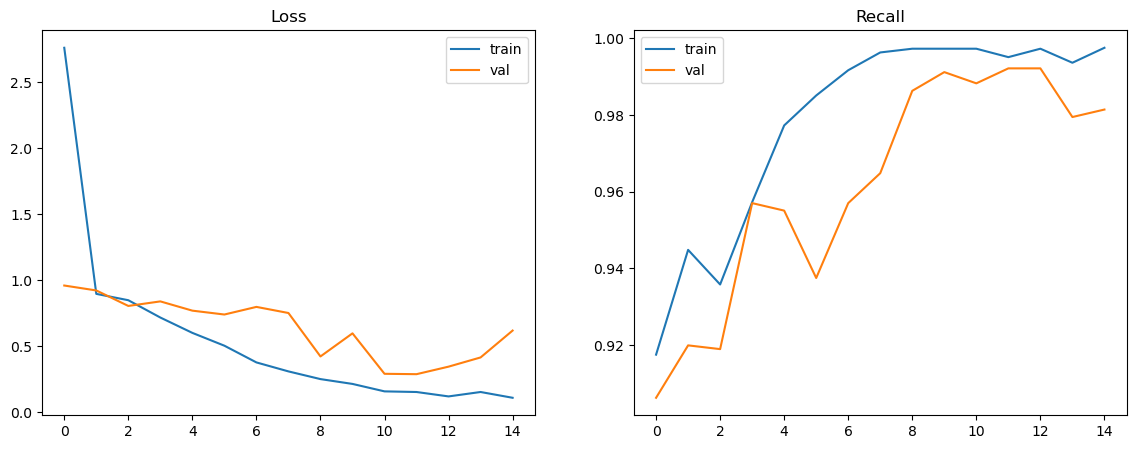

                  precision    recall  f1-score   support

    MildDementia       0.88      0.89      0.88       151
ModerateDementia       1.00      0.78      0.88         9
     NonDementia       0.90      0.92      0.91       507
VeryMildDementia       0.88      0.85      0.86       357

        accuracy                           0.89      1024
       macro avg       0.91      0.86      0.88      1024
    weighted avg       0.89      0.89      0.89      1024



In [ ]:
# Plot loss and recall
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['recall_11'], label='train')
plt.plot(history.history['val_recall_11'], label='val')
plt.title('Recall')
plt.legend()
plt.show()

# Classification report
print(classification_report(labels_val, preds_val, target_names=class_names))

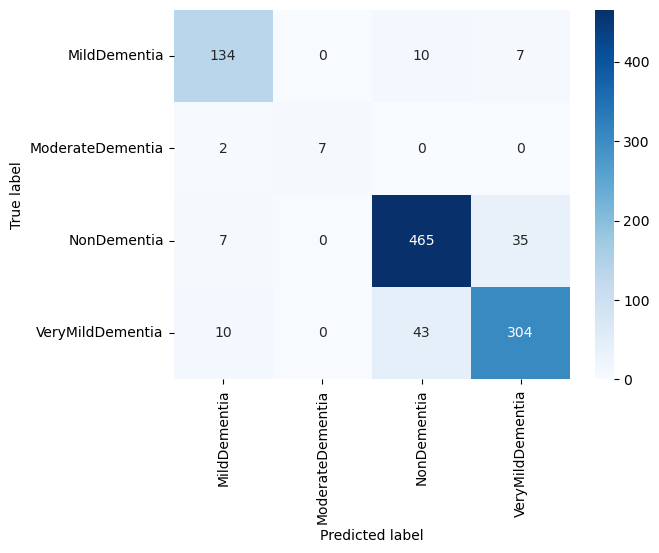

In [ ]:
# Confusion matrix
cm = confusion_matrix(labels_val, preds_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Binary Classification

In [ ]:
# For Binary Classification: Rearranging the files to two major folders signifying Demented and NonDemented
!mv "/content/Alzheimer_s Dataset/train/VeryMildDemented/"* "/content/Alzheimer_s Dataset/train/ModerateDemented/"
!mv "/content/Alzheimer_s Dataset/train/MildDemented/"* "/content/Alzheimer_s Dataset/train/ModerateDemented/"

!mv "/content/Alzheimer_s Dataset/test/VeryMildDemented/"* "/content/Alzheimer_s Dataset/test/ModerateDemented/"
!mv "/content/Alzheimer_s Dataset/test/MildDemented/"* "/content/Alzheimer_s Dataset/test/ModerateDemented/"

In [196]:
  # !rm -r "/content/Alzheimer_s Dataset/"*

In [ ]:
!ls "/content/Alzheimer_s Dataset/test"

Demented  NonDemented


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

INIT_LR = 1e-4
EPOCHS = 50
BS = 32

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 100

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Alzheimer_s Dataset/train/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'  # add this line to make labels binary
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Alzheimer_s Dataset/train/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'  # add this line to make labels binary
)

class_names = ['ModerateDemented', 'NonDemented']
train_ds.class_names = class_names
val_ds.class_names = class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(train_ds.class_names[labels[i]])
#     plt.axis("off")

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
    Conv2D(16, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')  # binary classification
])

# Compile model with recall as a metric
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = [tf.keras.metrics.Recall()])

history = model.fit(train_ds, epochs=25, validation_data=val_ds)


Number of replicas: 1
2.12.0
Found 5121 files belonging to 2 classes.
Using 4097 files for training.
Found 5121 files belonging to 2 classes.
Using 1024 files for validation.
Epoch 1/25
257/257 [==============================] - 5s 9ms/step - loss: 1.5272 - recall_4: 0.6423 - val_loss: 0.7548 - val_recall_4: 0.2779
Epoch 2/25
257/257 [==============================] - 2s 7ms/step - loss: 0.6104 - recall_4: 0.6833 - val_loss: 0.5633 - val_recall_4: 0.6771
Epoch 3/25
257/257 [==============================] - 2s 7ms/step - loss: 0.5531 - recall_4: 0.7052 - val_loss: 0.5349 - val_recall_4: 0.6223
Epoch 4/25
257/257 [==============================] - 2s 7ms/step - loss: 0.4821 - recall_4: 0.7399 - val_loss: 0.4692 - val_recall_4: 0.6125
Epoch 5/25
257/257 [==============================] - 2s 7ms/step - loss: 0.4266 - recall_4: 0.7857 - val_loss: 0.4390 - val_recall_4: 0.6458
Epoch 6/25
257/257 [==============================] - 2s 7ms/step - loss: 0.3553 - recall_4: 0.8306 - val_loss: 0.3

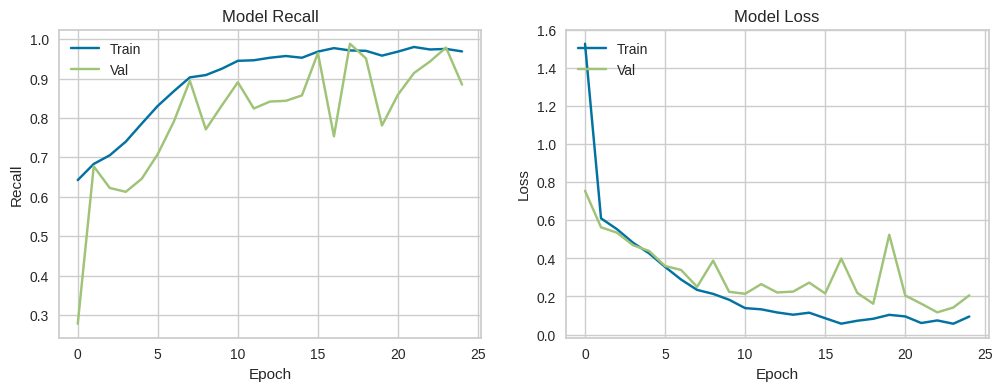

64/64 [==============================] - 0s 3ms/step


ValueError: ignored

In [ ]:
# Plot the recall and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['recall_4'])
plt.plot(history.history['val_recall_4'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Prediction
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion Matrix
# conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
# plt.figure(figsize=(10, 10))
# sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.show()

In [ ]:
!rm -r "/content/Alzheimer_s Dataset/test/.ipynb_checkpoints/"

In [ ]:
# Testing
# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'  # add this line to make labels binary
)

print(test_ds.class_names)

Found 1098 files belonging to 2 classes.
['ModerateDemented', 'NonDemented']


In [ ]:

# No need to one-hot encode for binary classification
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Evaluate the model on the test dataset
test_loss, test_recall = model.evaluate(test_ds)

print("Test loss:", test_loss)
print("Test recall:", test_recall)


69/69 [==============================] - 0s 4ms/step - loss: 1.5749 - recall_4: 0.6172
Test loss: 1.5749421119689941
Test recall: 0.6171875


In [ ]:
#Saving the model for future use
work_dir = "/kaggle/working/"
model_dir = work_dir + "alzheimer_cnn_model"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_cnn_model']

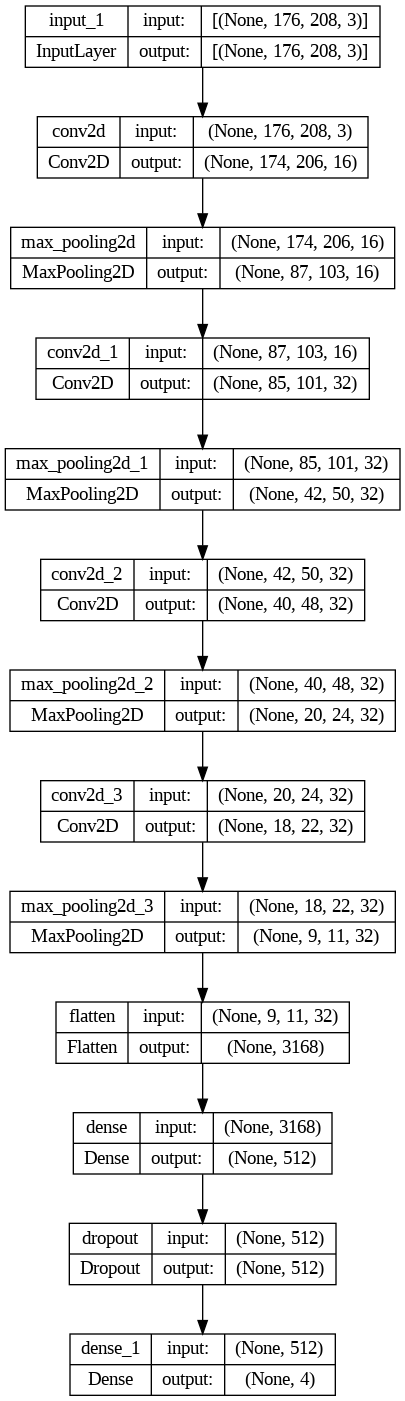

In [ ]:
pretrained_model = tf.keras.models.load_model(model_dir)

from keras.utils.vis_utils import plot_model
#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

## DL with ML

In [48]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [49]:
# Extract features from the test set
features_test = model.predict(test_ds)

# Convert labels to numpy arrays
labels_test = np.concatenate([y.numpy().argmax(axis=1) for x, y in test_ds], axis=0)

# Use RF for prediction on test set
preds_test = et.predict(features_test)

# Calculate accuracy on the test set
accuracy_test = np.sum(preds_test == labels_test) / len(labels_test)
print("Test accuracy: {:.2f}%".format(accuracy_test * 100))

# Print the classification report for the test set
print(classification_report(labels_test, preds_test, target_names=class_names))

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(labels_test, preds_test)

# Plot the confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

80/80 [==============================] - 0s 4ms/step


ValueError: ignored